<style>
@media (prefers-color-scheme: dark) {
    .autosense-logo {
        filter: brightness(0) invert(1);
    }
}
</style>

<div style="text-align: center;">
    <img src="./images/logo.svg" alt="Drawing" style="width: 5%;"/> <br>
    <img src="./images/autosense.svg" alt="Drawing" class="autosense-logo" style="width: 10%;"/>
</div>

<h1 style="text-align: center;">AutoSense - EV Charging</h1>


## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li>
    <a href="#wrangling">Data Wrangling</a>
    <ul>
        <li><a href="#gathering">Gathering</a></li>
        <li><a href="#assessing">Assessing</a></li>
        <li><a href="#opservation">Opservations</a></li>
        <li><a href="#cleansing">Cleansing and Transformation</a></li>
    </ul>
</li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>


<a id='intro'></a>

### Introduction

This notebook presents a comprehensive **Data Quality Assessment** for AutoSense's EV Charging Analytics Pipeline. The analysis is part of **Task 1: Data Loading & Quality Assessment**, which focuses on identifying, documenting, and proposing solutions for data quality issues in the simulated EV charging dataset.


##### Importing External Libraries and helper functions


In [1]:
# Loading autoreload to avoid reimporting helper functions
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ydata_profiling import ProfileReport
try:
    from helper import *
except ModuleNotFoundError as e:
    from analyses.helper import *

# Display charts inline
%matplotlib inline

# Setting color pallete and theme to use
sns.set_theme(style='white', palette='colorblind')
COLOR_LIGHT_GREEN = "#4CD9A4"
COLOR_GRAY = '#4a4d4e'
COLOR_PURPLE = '#2E1052'
COLOR_GREEN = '#00b159'
COLOR_RED = "#e60000"
COLOR_YELLOW = '#fecb00'

TITLEFONT = {'fontsize': 20, 'fontweight':'bold'}
AXISFONT = {'fontsize': 14}

# Set pandas to display all columns
pd.options.display.max_columns = None

# Set the input and output directories
DATA_DIR = Path('./data')
OUTPUT_DIR = DATA_DIR / 'output'
PATH_CHARGERS = DATA_DIR / 'chargers.json'
PATH_PAYMENTS = DATA_DIR / 'payments.json'
PATH_TRANSACTIONS = DATA_DIR / 'transactions.json'
PATH_USERS = DATA_DIR / 'users.json'


<a id='wrangling'></a>

## Data Wrangling


<a id='gathering'></a>

### Gathering the data

The data is available in 4 json files already downloaded in the `data/` folder.


In [ ]:
# Load the chargers data
df_chargers = pd.read_json(PATH_CHARGERS)
df_chargers.head()


,charger_id,city,location,installed_at
0,charger_1,Lausanne,"{'lat': 46.533429, 'lon': 6.642148}",2023-03-26 15:50:52.566000+00:00
1,charger_2,Lucerne,"{'lat': 47.037157, 'lon': 8.320008}",2022-10-08 10:00:41.109000+00:00
2,charger_3,Bern,"{'lat': 46.957913, 'lon': 7.453251}",2024-02-25 12:49:48.493000+00:00
3,charger_4,Lucerne,"{'lat': 47.060813, 'lon': 8.312696}",2023-08-08 15:48:04.505000+00:00
4,charger_5,Lugano,"{'lat': 46.011992, 'lon': 8.957525}",2023-03-08 15:45:43.325000+00:00


In [ ]:
# Normalize the location to 2 columns: latitude and longitude
df_location = pd.json_normalize(df_chargers["location"])
df_location.columns = ["latitude", "longitude"]
df_chargers = pd.concat([df_chargers.drop(columns=["location"]), df_location], axis=1)
df_chargers.head()


,charger_id,city,installed_at,latitude,longitude
0,charger_1,Lausanne,2023-03-26 15:50:52.566000+00:00,46.533429,6.642148
1,charger_2,Lucerne,2022-10-08 10:00:41.109000+00:00,47.037157,8.320008
2,charger_3,Bern,2024-02-25 12:49:48.493000+00:00,46.957913,7.453251
3,charger_4,Lucerne,2023-08-08 15:48:04.505000+00:00,47.060813,8.312696
4,charger_5,Lugano,2023-03-08 15:45:43.325000+00:00,46.011992,8.957525


In [ ]:
# load the payments data
df_payments = pd.read_json(PATH_PAYMENTS)
df_payments.head()


,payment_id,session_id,user_id,amount,currency
0,payment_1,session_1,user_493,4.73,CHF
1,payment_2,session_2,user_189,10.24,CHF
2,payment_3,session_3,user_59,2.46,CHF
3,payment_4,session_4,user_274,14.38,CHF
4,payment_5,session_5,user_1825,7.83,CHF


In [ ]:
# load the users data
df_users = pd.read_json(PATH_USERS)
df_users.head()


,user_id,name,email,tier,created_at
0,user_1,Mr. Marcus Buckridge,Queenie26@yahoo.com,guest,2023-06-25 19:14:29.518000+00:00
1,user_2,Tracy Bins DDS,Cristal.Padberg@hotmail.com,guest,2024-11-14 07:26:25.333000+00:00
2,user_3,Saul Goldner,Percy.Greenholt@hotmail.com,guest,2023-08-05 17:58:05.258000+00:00
3,user_4,Vicky Stanton,Rita_Bailey46@gmail.com,guest,2025-02-28 19:13:56.529000+00:00
4,user_5,Clifford Breitenberg,Nina_OKeefe@yahoo.com,guest,2024-12-18 22:39:07.496000+00:00


In [ ]:
# load the transactions data
df_transactions = pd.read_json(PATH_TRANSACTIONS)
df_transactions.head()


,session_id,user_id,charger_id,start_time,end_time,kWh_consumed,payment_method,status
0,session_1,user_493,charger_837,2025-01-11 09:44:27.416000+00:00,2025-01-11 10:41:27.416000+00:00,9.46,app_wallet,completed
1,session_2,user_189,charger_1355,2025-04-18 12:48:06.929000+00:00,2025-04-18 14:31:06.929000+00:00,20.49,card,completed
2,session_3,user_59,charger_2814,2025-03-15 16:04:13.267000+00:00,2025-03-15 16:21:13.267000+00:00,4.91,app_wallet,completed
3,session_4,user_274,charger_1930,2025-03-29 15:34:14.324000+00:00,2025-03-29 17:12:14.324000+00:00,28.75,card,completed
4,session_5,user_1825,charger_2625,2025-04-23 04:42:51.722000+00:00,2025-04-23 05:36:51.722000+00:00,15.67,app_wallet,completed


Saving the data as excel files for visual inspection.


In [ ]:
# # Save to Excel with timezone-naive datetimes
# remove_timezone(df_chargers).to_excel(OUTPUT_DIR / "chargers.xlsx", index=False)
# remove_timezone(df_payments).to_excel(OUTPUT_DIR / "payments.xlsx", index=False)
# remove_timezone(df_users).to_excel(OUTPUT_DIR / "users.xlsx", index=False)
# remove_timezone(df_transactions).to_excel(OUTPUT_DIR / "transactions.xlsx", index=False)


<a id='assessing'></a>

### Assessing the Data

Assessing the 4 dataframes to determine the data quality and tideness issues using visual assessment from the Excel file as well as programming using pandas methods


#### Assessing chargers dataframe


In [ ]:
# Display the info of chargers dataframe
df_chargers.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   charger_id    3000 non-null   object             
 1   city          3000 non-null   object             
 2   installed_at  3000 non-null   datetime64[ns, UTC]
 3   latitude      3000 non-null   float64            
 4   longitude     3000 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 117.3+ KB


In [ ]:
# Display the summary statistics of chargers dataframe
df_chargers.describe(include="all")


,charger_id,city,installed_at,latitude,longitude
count,3000,3000,3000,3000.000000,3000.000000
unique,3000,11,NaN,NaN,NaN
top,charger_1,Bern,NaN,NaN,NaN
freq,1,403,NaN,NaN,NaN
mean,NaN,NaN,2023-11-28 16:08:36.808732672+00:00,47.987494,9.179583
min,NaN,NaN,2022-06-04 23:20:42.010000+00:00,-75.250973,-151.200000
25%,NaN,NaN,2023-03-05 03:32:46.956249856+00:00,46.223805,6.652222
50%,NaN,NaN,2023-11-30 16:02:19.849999872+00:00,46.965216,7.604617
75%,NaN,NaN,2024-08-16 08:48:32.452999936+00:00,47.396539,8.561128
max,NaN,NaN,2025-06-02 17:56:27.626000+00:00,1000.000000,1000.000000


In [ ]:
# Check the missing values in chargers dataframe
df_chargers.isnull().sum()


charger_id      0
city            0
installed_at    0
latitude        0
longitude       0
dtype: int64

In [ ]:
# Check the city column unique values
df_chargers["city"].unique()


array(['Lausanne', 'Lucerne', 'Bern', 'Lugano', 'Geneva', 'St. Gallen',
       'Basel', 'Zurich', 'Zürich', 'Sankt Gallen', 'Zuerich'],
      dtype=object)

In [ ]:
# Display the value counts of the city column
df_chargers["city"].value_counts()


city
Bern            403
Lugano          381
Basel           380
Lausanne        376
Zurich          372
Geneva          370
St. Gallen      361
Lucerne         350
Zuerich           3
Zürich            2
Sankt Gallen      2
Name: count, dtype: int64

Notice that Zurich `city` is misspelled as `Zuerich` in some records and also with accent like `Zürich` in some records that need to be unified.


In [ ]:
# Check the installed_at column for issues
df_chargers["installed_at"].describe()


count                                   3000
mean     2023-11-28 16:08:36.808732672+00:00
min         2022-06-04 23:20:42.010000+00:00
25%      2023-03-05 03:32:46.956249856+00:00
50%      2023-11-30 16:02:19.849999872+00:00
75%      2024-08-16 08:48:32.452999936+00:00
max         2025-06-02 17:56:27.626000+00:00
Name: installed_at, dtype: object

<Axes: >

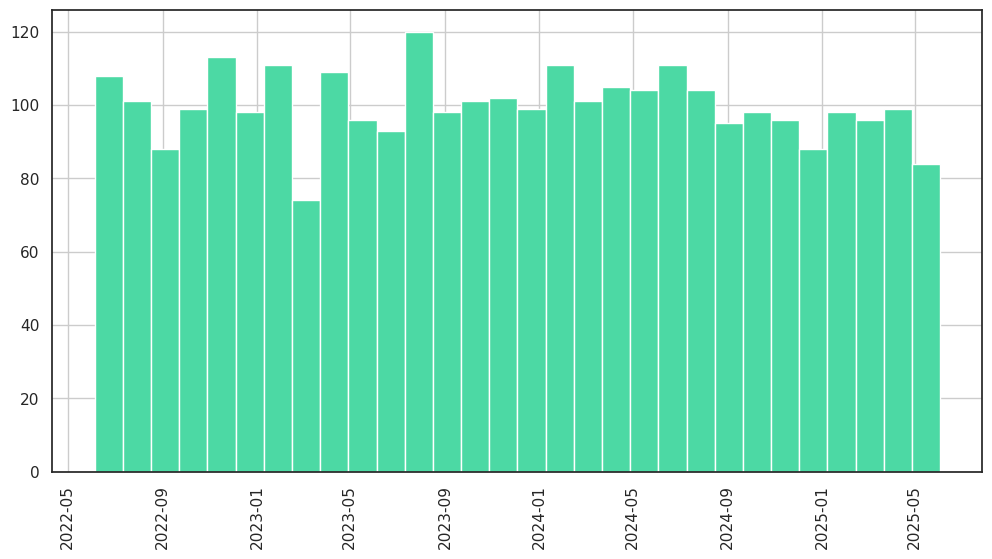

In [ ]:
# Plot the distribution of installed_at dates
df_chargers.installed_at.hist(
    bins=30, color=COLOR_LIGHT_GREEN, xrot=90, figsize=(12, 6)
)


`installed_at` column seems normally formatted and no timezone issues noticed.


In [ ]:
# Check the latitude and longitude columns for issues
df_chargers[["latitude", "longitude"]].describe()


,latitude,longitude
count,3000.000000,3000.000000
mean,47.987494,9.179583
std,35.129108,36.868589
min,-75.250973,-151.200000
25%,46.223805,6.652222
50%,46.965216,7.604617
75%,47.396539,8.561128
max,1000.000000,1000.000000


In [ ]:
# Check for validity of latitude and longitude values
is_invalid_location = check_invalid_location_in_ch(df_chargers)
df_chargers["is_invalid_location"] = is_invalid_location
df_chargers["is_invalid_location"].value_counts()


is_invalid_location
False    2983
True       17
Name: count, dtype: int64

In [ ]:
# Display the invalid location entries
df_chargers[df_chargers["is_invalid_location"] == False]


,charger_id,city,installed_at,latitude,longitude,is_invalid_location
0,charger_1,Lausanne,2023-03-26 15:50:52.566000+00:00,46.533429,6.642148,False
1,charger_2,Lucerne,2022-10-08 10:00:41.109000+00:00,47.037157,8.320008,False
2,charger_3,Bern,2024-02-25 12:49:48.493000+00:00,46.957913,7.453251,False
3,charger_4,Lucerne,2023-08-08 15:48:04.505000+00:00,47.060813,8.312696,False
4,charger_5,Lugano,2023-03-08 15:45:43.325000+00:00,46.011992,8.957525,False
...,...,...,...,...,...,...
2995,charger_2996,Basel,2025-05-08 07:08:46.719000+00:00,47.568176,7.578654,False
2996,charger_2997,Zurich,2024-07-24 23:23:45.458000+00:00,47.389826,8.523503,False
2997,charger_2998,Lausanne,2023-04-18 15:16:29.187000+00:00,46.524565,6.644819,False
2998,charger_2999,Lugano,2024-02-19 19:08:44.298000+00:00,46.019977,8.944945,False


In [ ]:
df_chargers["city_from_coords"] = get_city_from_location(
    df_chargers, lat_col="latitude", lon_col="longitude"
)


Loading formatted geocoded file...


In [ ]:
df_chargers


,charger_id,city,installed_at,latitude,longitude,is_invalid_location,city_from_coords
0,charger_1,Lausanne,2023-03-26 15:50:52.566000+00:00,46.533429,6.642148,False,Lausanne
1,charger_2,Lucerne,2022-10-08 10:00:41.109000+00:00,47.037157,8.320008,False,Luzern
2,charger_3,Bern,2024-02-25 12:49:48.493000+00:00,46.957913,7.453251,False,Bern
3,charger_4,Lucerne,2023-08-08 15:48:04.505000+00:00,47.060813,8.312696,False,Luzern
4,charger_5,Lugano,2023-03-08 15:45:43.325000+00:00,46.011992,8.957525,False,Lugano
...,...,...,...,...,...,...,...
2995,charger_2996,Basel,2025-05-08 07:08:46.719000+00:00,47.568176,7.578654,False,Basel
2996,charger_2997,Zurich,2024-07-24 23:23:45.458000+00:00,47.389826,8.523503,False,Zuerich (Kreis 5)
2997,charger_2998,Lausanne,2023-04-18 15:16:29.187000+00:00,46.524565,6.644819,False,Lausanne
2998,charger_2999,Lugano,2024-02-19 19:08:44.298000+00:00,46.019977,8.944945,False,Massagno


In [ ]:
df_chargers["city_from_coords"].value_counts()


city_from_coords
Bern                           380
Sankt Gallen                   322
Luzern                         295
Geneve                         241
Lausanne                       231
                              ... 
Edinburgh of the Seven Seas      2
Constantia                       1
Canobbio                         1
Zuerich (Kreis 8)                1
Hugh Town                        1
Name: count, Length: 62, dtype: int64

In [ ]:
df_chargers["city_from_coords"].unique()


array(['Lausanne', 'Luzern', 'Bern', 'Lugano', 'Le Grand-Saconnex',
       'Carouge', 'Sankt Gallen', 'Sorengo', 'Koniz', 'Basel',
       'Zuerich (Kreis 1)', 'Geneve', 'Zuerich (Kreis 6)', 'Viganello',
       'Massagno', 'Binningen', 'Blecherette', 'Kriens', 'Campione',
       'Birsfelden', 'Emmen', 'Zuerich (Kreis 1) / Lindenhof', 'Tiksi',
       'Zuerich (Kreis 2) / Enge', 'Wittenbach', 'Aussersihl', 'Teufen',
       'Zuerich (Kreis 6) / Oberstrass',
       'Zuerich (Kreis 5) / Gewerbeschule', 'Takoradi', 'Pully',
       'Zuerich (Kreis 1) / Rathaus', 'Zuerich (Kreis 4) / Langstrasse',
       'Zuerich (Kreis 4) / Werd', 'Zuerich (Kreis 5)', 'Zurich',
       'Zuerich (Kreis 7) / Hottingen', 'Weil am Rhein', 'Horw', 'Lancy',
       'Zuerich (Kreis 1) / City', 'Zuerich (Kreis 7) / Fluntern',
       'Zuerich (Kreis 8) / Muehlebach', 'Zuerich (Kreis 10) / Wipkingen',
       'Ebikon', 'Village-Neuf', 'Muri', 'Munchenstein', 'Pregassona',
       'Kehrsatz', 'Cadempino', 'Zuerich (Kreis 6) 

There are 17 records with invalid locations that need to be handled.


#### Assessing Payments dataframe


In [ ]:
# Display the info of payments dataframe
df_payments.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91876 entries, 0 to 91875
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   payment_id  91876 non-null  object 
 1   session_id  91876 non-null  object 
 2   user_id     91876 non-null  object 
 3   amount      91876 non-null  float64
 4   currency    91876 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.5+ MB


In [ ]:
# Display the summary statistics of payments dataframe
df_payments.describe(include="all")


,payment_id,session_id,user_id,amount,currency
count,91876,91876,91876,91876.000000,91876
unique,91876,91876,2000,NaN,1
top,payment_1,session_1,user_1106,NaN,CHF
freq,1,1,68,NaN,91876
mean,NaN,NaN,NaN,43.849383,NaN
std,NaN,NaN,NaN,1457.524067,NaN
min,NaN,NaN,NaN,-24.910000,NaN
25%,NaN,NaN,NaN,4.430000,NaN
50%,NaN,NaN,NaN,8.450000,NaN
75%,NaN,NaN,NaN,13.220000,NaN


In [ ]:
# Check for issues in amount column
df_payments["amount"].describe()


count    91876.000000
mean        43.849383
std       1457.524067
min        -24.910000
25%          4.430000
50%          8.450000
75%         13.220000
max      99502.120000
Name: amount, dtype: float64

<Axes: >

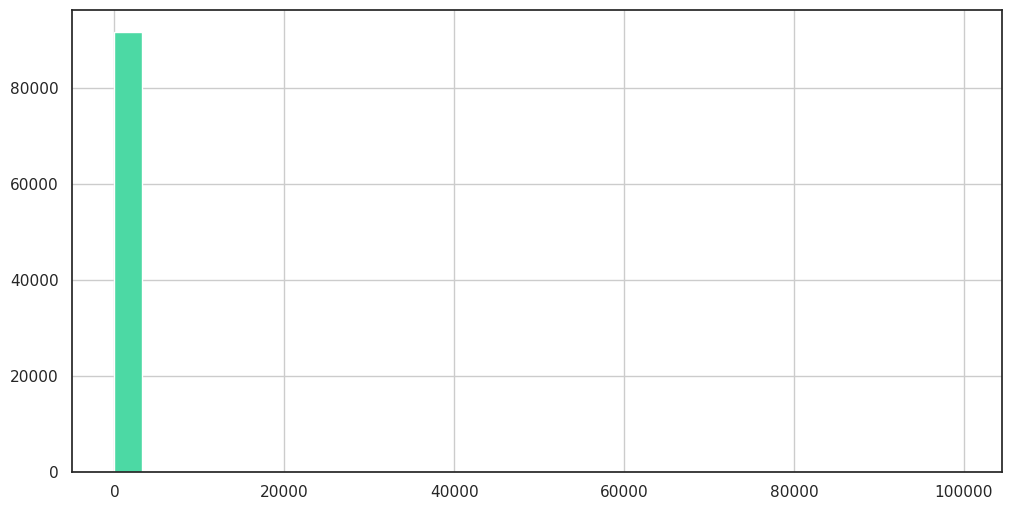

In [ ]:
df_payments["amount"].hist(bins=30, color=COLOR_LIGHT_GREEN, figsize=(12, 6))


In [ ]:
# Get the number of payments with 0 or negative amount
num_invalid_payments = df_payments[df_payments["amount"] <= 0].shape[0]
print(f"Number of payments with 0 or negative amount: {num_invalid_payments}")


Number of payments with 0 or negative amount: 262


In [ ]:
# Show the payments with 0 or negative amount
df_payments[df_payments["amount"] <= 0]


,payment_id,session_id,user_id,amount,currency
435,payment_436,session_480,user_803,-23.49,CHF
841,payment_842,session_913,user_1523,-4.87,CHF
1241,payment_1242,session_1354,user_1756,-22.43,CHF
1684,payment_1685,session_1829,user_672,-3.39,CHF
1848,payment_1849,session_2009,user_1409,-7.39,CHF
...,...,...,...,...,...
90732,payment_90733,session_98756,user_1755,0.00,CHF
90786,payment_90787,session_98816,user_853,-12.22,CHF
91255,payment_91256,session_99324,user_1755,-1.75,CHF
91379,payment_91380,session_99462,user_922,-6.49,CHF


In [ ]:
# Get the number of payments with very high amount (e.g., > $1000)
num_high_amount_payments = df_payments[df_payments["amount"] > 30].shape[0]
print(f"Number of payments with amount greater than $1000: {num_high_amount_payments}")


Number of payments with amount greater than $1000: 260


In [ ]:
# Show the high amount payments
df_payments[df_payments["amount"] > 30]


,payment_id,session_id,user_id,amount,currency
907,payment_908,session_988,user_1074,2139.05,CHF
1008,payment_1009,session_1097,user_801,1731.95,CHF
1595,payment_1596,session_1733,user_1349,1066.17,CHF
1917,payment_1918,session_2085,user_1202,1952.75,CHF
2030,payment_2031,session_2212,user_21,2085.82,CHF
...,...,...,...,...,...
89821,payment_89822,session_97770,user_1061,3146.94,CHF
89948,payment_89949,session_97907,user_204,1061.25,CHF
90345,payment_90346,session_98327,user_986,3519.52,CHF
90425,payment_90426,session_98415,user_1113,3229.16,CHF


<Axes: >

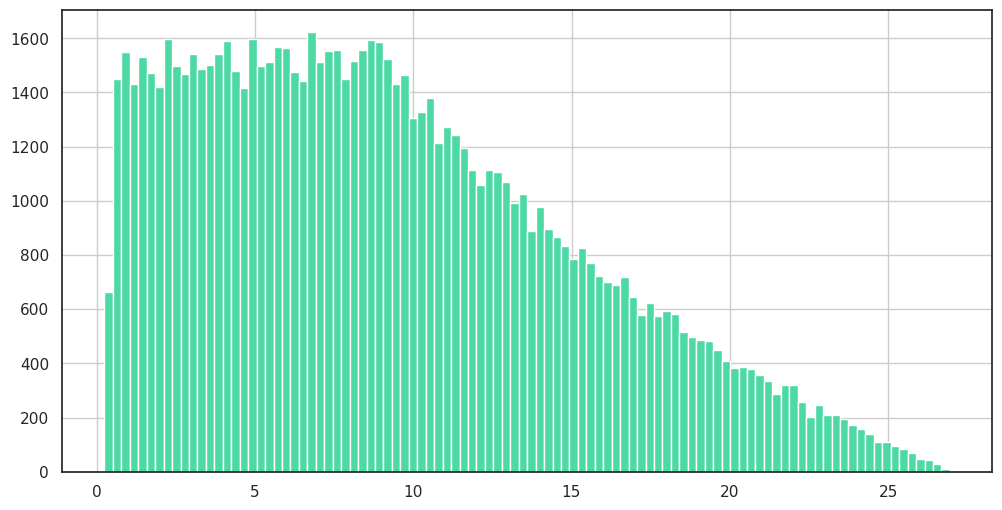

In [ ]:
# Display histogram of payments amount after removing outliers
df_payments_filtered = df_payments[
    (df_payments["amount"] < 30) & (df_payments["amount"] > 0)
]
df_payments_filtered["amount"].hist(bins=100, color=COLOR_LIGHT_GREEN, figsize=(12, 6))


In [ ]:
# Display value counts of payments with 0 or negative amount
df_payments[df_payments["amount"] <= 0]["amount"].value_counts()


amount
 0.00     49
-1.64      3
-0.14      2
-14.26     2
-3.08      2
          ..
-15.93     1
-3.45      1
-12.22     1
-1.75      1
-6.49      1
Name: count, Length: 201, dtype: int64

In [ ]:
# Display the value counts of high amount payments
df_payments[df_payments["amount"] > 30]["amount"].value_counts()


amount
2139.05    1
1731.95    1
1066.17    1
1952.75    1
2085.82    1
          ..
3146.94    1
1061.25    1
3519.52    1
3229.16    1
1679.47    1
Name: count, Length: 260, dtype: int64

In [ ]:
df_payments[df_payments["amount"] > 30]["amount"].describe()


count      260.000000
mean     12248.534000
std      24568.537726
min        547.810000
25%       1504.907500
50%       2600.380000
75%       4445.830000
max      99502.120000
Name: amount, dtype: float64

- `amount` column has negative values that need to be handled.
- `amount` column has very high values that need to be handled.


#### Assessing the users dataframe


In [ ]:
# Display the info of users dataframe
df_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   user_id     2000 non-null   object             
 1   name        2000 non-null   object             
 2   email       2000 non-null   object             
 3   tier        2000 non-null   object             
 4   created_at  2000 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 78.3+ KB


In [ ]:
# Display the Summary statistics of users dataframe
df_users.describe(include="all")


,user_id,name,email,tier,created_at
count,2000,2000,2000,2000,2000
unique,2000,2000,2000,2,NaN
top,user_1,Mr. Marcus Buckridge,Queenie26@yahoo.com,subscriber,NaN
freq,1,1,1,1036,NaN
mean,NaN,NaN,NaN,NaN,2024-05-29 04:17:28.644699904+00:00
min,NaN,NaN,NaN,NaN,2023-06-04 14:52:30.486000+00:00
25%,NaN,NaN,NaN,NaN,2023-11-19 13:19:06.715249920+00:00
50%,NaN,NaN,NaN,NaN,2024-05-25 21:46:21.360000+00:00
75%,NaN,NaN,NaN,NaN,2024-11-28 21:07:59.331500032+00:00
max,NaN,NaN,NaN,NaN,2025-06-03 06:15:09.868000+00:00


In [ ]:
# Check for valid emails
is_valid_email = df_users["email"].apply(check_valid_email)
df_users["is_valid_email"] = is_valid_email
df_users["is_valid_email"].value_counts()


is_valid_email
True    2000
Name: count, dtype: int64

<Axes: >

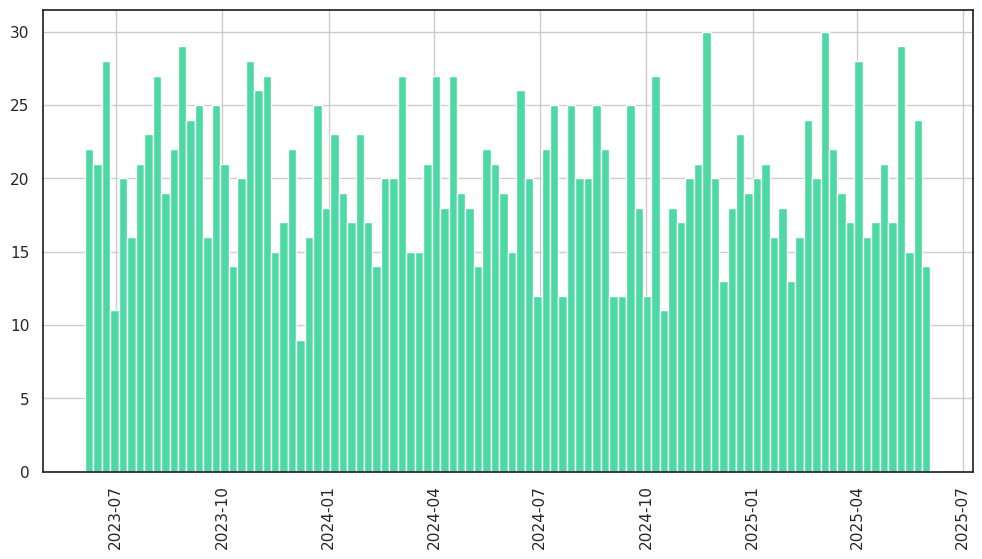

In [ ]:
# Display histogram of created_at dates
df_users.created_at.hist(bins=100, color=COLOR_LIGHT_GREEN, xrot=90, figsize=(12, 6))


Nothing unusual noticed in the users dataframe.


#### Assessing transactions dataframe


In [ ]:
# Display the info of transactions dataframe
df_transactions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   session_id      100000 non-null  object             
 1   user_id         100000 non-null  object             
 2   charger_id      100000 non-null  object             
 3   start_time      100000 non-null  datetime64[ns, UTC]
 4   end_time        91876 non-null   datetime64[ns, UTC]
 5   kWh_consumed    100000 non-null  float64            
 6   payment_method  100000 non-null  object             
 7   status          100000 non-null  object             
dtypes: datetime64[ns, UTC](2), float64(1), object(5)
memory usage: 6.1+ MB


In [ ]:
# Display the summary statistics of transactions dataframe
df_transactions.describe(include="all")


,session_id,user_id,charger_id,start_time,end_time,kWh_consumed,payment_method,status
count,100000,100000,100000,100000,91876,100000.000000,100000,100000
unique,100000,2000,3000,NaN,NaN,NaN,3,2
top,session_1,user_387,charger_66,NaN,NaN,NaN,card,completed
freq,1,72,57,NaN,NaN,NaN,33340,91876
mean,NaN,NaN,NaN,2025-03-17 16:38:18.777330176+00:00,2025-03-17 18:10:55.033989376+00:00,27.695507,NaN,NaN
min,NaN,NaN,NaN,2025-01-01 00:01:55.513000+00:00,2025-01-01 00:09:24.718000+00:00,-49.830000,NaN,NaN
25%,NaN,NaN,NaN,2025-02-07 20:25:02.975000064+00:00,2025-02-07 21:31:17.375749888+00:00,6.737500,NaN,NaN
50%,NaN,NaN,NaN,2025-03-18 01:27:13.409999872+00:00,2025-03-18 01:09:07.525500160+00:00,15.480000,NaN,NaN
75%,NaN,NaN,NaN,2025-04-24 14:23:57.671749888+00:00,2025-04-24 17:03:08.817250048+00:00,25.410000,NaN,NaN
max,NaN,NaN,NaN,2025-05-31 23:59:53.633000+00:00,2025-06-12 01:56:09.190000+00:00,9930.310000,NaN,NaN


<Axes: >

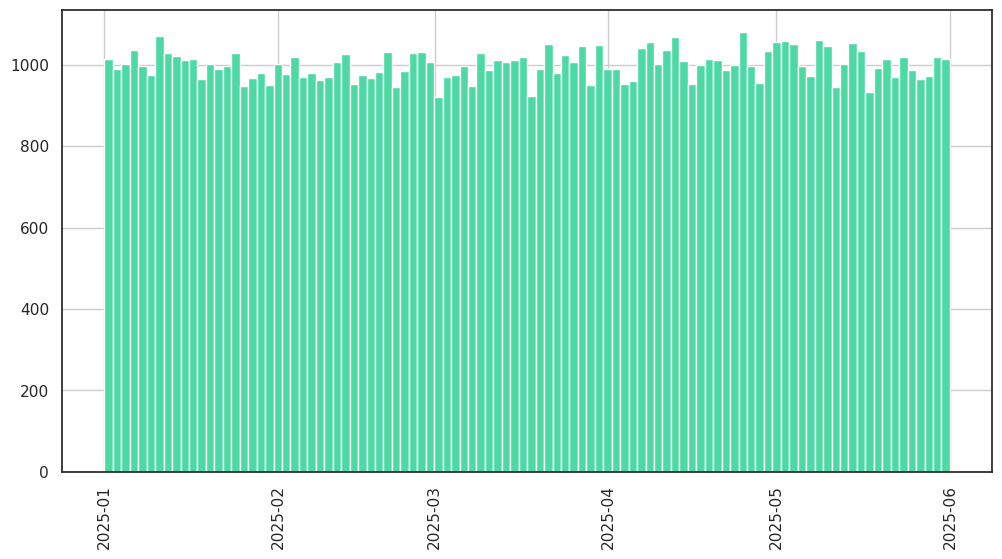

In [ ]:
# Display the histogram of the start_time
df_transactions.start_time.hist(
    bins=100, color=COLOR_LIGHT_GREEN, xrot=90, figsize=(12, 6)
)


<Axes: >

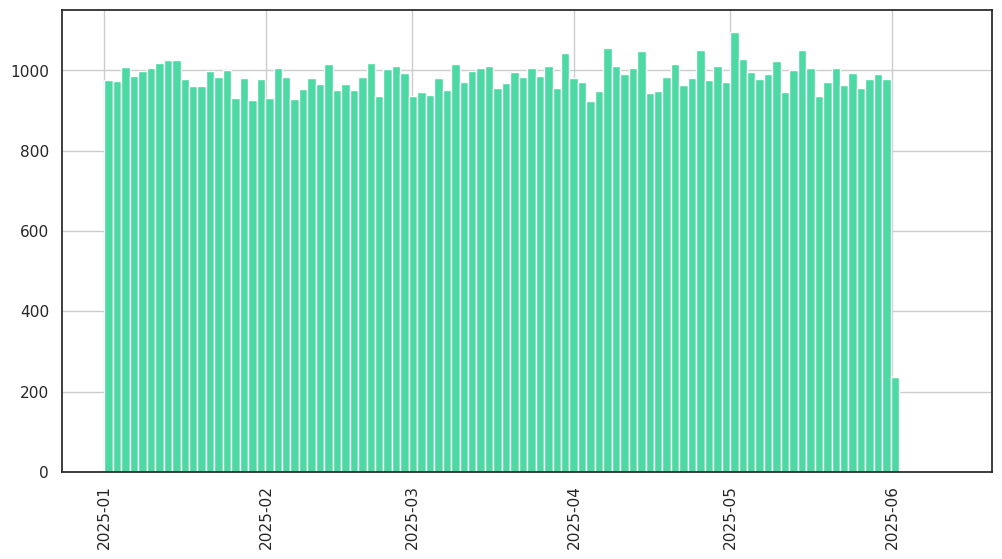

In [ ]:
# Display the histogram of the end_time
df_transactions.end_time.hist(
    bins=100, color=COLOR_LIGHT_GREEN, xrot=90, figsize=(12, 6)
)


<Axes: >

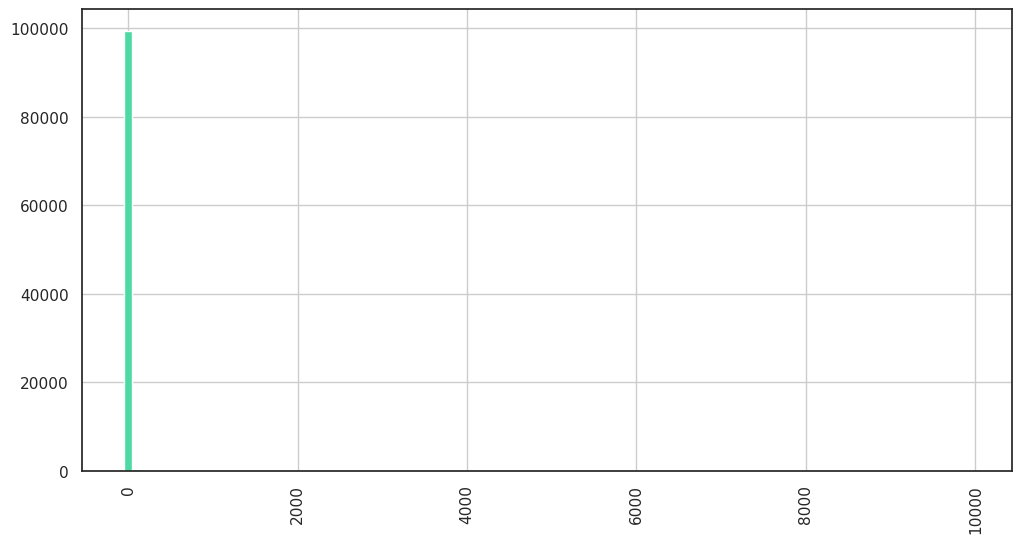

In [ ]:
# Display the histogram of the kwh_consumed
df_transactions.kWh_consumed.hist(
    bins=100, color=COLOR_LIGHT_GREEN, xrot=90, figsize=(12, 6)
)


In [ ]:
# Diplay the kWh_consumed with 0 or negative values
df_transactions[df_transactions["kWh_consumed"] <= 0]


,session_id,user_id,charger_id,start_time,end_time,kWh_consumed,payment_method,status
9,session_10,user_131,charger_2796,2025-04-17 14:54:58.613000+00:00,NaT,0.0,app_wallet,failed
20,session_21,user_1337,charger_2757,2025-01-07 00:23:35.824000+00:00,NaT,0.0,card,failed
53,session_54,user_1453,charger_1340,2025-03-13 11:40:25.450000+00:00,NaT,0.0,card,failed
60,session_61,user_247,charger_2548,2025-04-24 01:40:52.430000+00:00,NaT,0.0,card,failed
61,session_62,user_262,charger_1985,2025-05-22 15:49:21.445000+00:00,NaT,0.0,app_wallet,failed
...,...,...,...,...,...,...,...,...
99964,session_99965,user_1257,charger_77,2025-04-26 02:37:28.540000+00:00,NaT,0.0,card,failed
99979,session_99980,user_1639,charger_2692,2025-04-18 09:41:01.176000+00:00,NaT,0.0,card,failed
99984,session_99985,user_210,charger_2824,2025-05-15 09:49:05.748000+00:00,NaT,0.0,card,failed
99987,session_99988,user_1885,charger_2646,2025-04-18 05:53:38.547000+00:00,NaT,0.0,card,failed


In [ ]:
df_transactions[df_transactions["kWh_consumed"] <= 0].status.value_counts()


status
failed       8124
completed     214
Name: count, dtype: int64

In [ ]:
df_transactions[
    (df_transactions["kWh_consumed"] <= 0) & (df_transactions["status"] == "completed")
]


,session_id,user_id,charger_id,start_time,end_time,kWh_consumed,payment_method,status
479,session_480,user_803,charger_1039,2025-02-08 23:52:00.067000+00:00,2025-02-19 08:17:00.067000+00:00,-46.98,card,completed
912,session_913,user_1523,charger_2536,2025-01-22 21:55:16.614000+00:00,2025-01-22 22:49:16.614000+00:00,-9.73,app_wallet,completed
1353,session_1354,user_1756,charger_747,2025-03-15 20:31:34.258000+00:00,2025-03-15 21:48:34.258000+00:00,-44.85,card,completed
1828,session_1829,user_672,charger_786,2025-03-10 18:06:42.420000+00:00,2025-03-10 17:35:42.420000+00:00,-6.78,RFID,completed
2008,session_2009,user_1409,charger_2587,2025-01-11 08:39:47.084000+00:00,2025-01-18 14:32:47.084000+00:00,-14.78,card,completed
...,...,...,...,...,...,...,...,...
98664,session_98665,user_487,charger_2478,2025-05-31 05:37:29.378000+00:00,2025-05-31 06:58:29.378000+00:00,-31.86,card,completed
98676,session_98677,user_628,charger_37,2025-01-14 12:26:42.890000+00:00,2025-01-14 11:42:42.890000+00:00,-6.90,app_wallet,completed
98815,session_98816,user_853,charger_1610,2025-04-28 04:08:06.553000+00:00,2025-04-28 03:19:06.553000+00:00,-24.44,RFID,completed
99323,session_99324,user_1755,charger_2018,2025-04-19 15:39:39.513000+00:00,2025-04-19 15:26:39.513000+00:00,-3.51,app_wallet,completed


In [ ]:
# Display the very high kWh_consumed values (e.g., > 100 kWh)
df_transactions[df_transactions["kWh_consumed"] > 100]


,session_id,user_id,charger_id,start_time,end_time,kWh_consumed,payment_method,status
987,session_988,user_1074,charger_2989,2025-03-03 09:49:41.577000+00:00,2025-03-12 04:19:41.577000+00:00,4278.09,app_wallet,completed
1096,session_1097,user_801,charger_467,2025-04-18 23:09:29.243000+00:00,2025-04-18 23:01:29.243000+00:00,3463.91,app_wallet,completed
1732,session_1733,user_1349,charger_2804,2025-03-04 01:39:17.376000+00:00,2025-03-12 18:29:17.376000+00:00,2132.35,RFID,completed
2084,session_2085,user_1202,charger_343,2025-05-24 04:51:45.442000+00:00,2025-06-06 09:42:45.442000+00:00,3905.50,card,completed
2211,session_2212,user_21,charger_1090,2025-03-21 05:59:46.556000+00:00,2025-03-21 08:52:46.556000+00:00,4171.65,card,completed
...,...,...,...,...,...,...,...,...
97769,session_97770,user_1061,charger_1604,2025-04-27 06:57:53.002000+00:00,2025-05-10 19:18:53.002000+00:00,6293.88,app_wallet,completed
97906,session_97907,user_204,charger_1855,2025-01-20 21:33:26.463000+00:00,2025-02-02 21:45:26.463000+00:00,2122.50,app_wallet,completed
98326,session_98327,user_986,charger_1518,2025-01-05 15:26:12.017000+00:00,2025-01-05 15:39:12.017000+00:00,7039.04,RFID,completed
98414,session_98415,user_1113,charger_1733,2025-05-17 03:49:35.866000+00:00,2025-05-25 04:13:35.866000+00:00,6458.33,card,completed


In [ ]:
# Check the issues with charging time
df_transactions["charging_time"] = (
    df_transactions["end_time"] - df_transactions["start_time"]
).dt.total_seconds() / 3600  # in hours


In [ ]:
df_transactions["charging_time"].value_counts()


charging_time
2.300000      575
0.266667      575
1.966667      572
0.833333      569
1.433333      567
             ... 
0.642098        1
324.350000      1
312.200000      1
192.400000      1
0.772042        1
Name: count, Length: 426, dtype: int64

<Axes: >

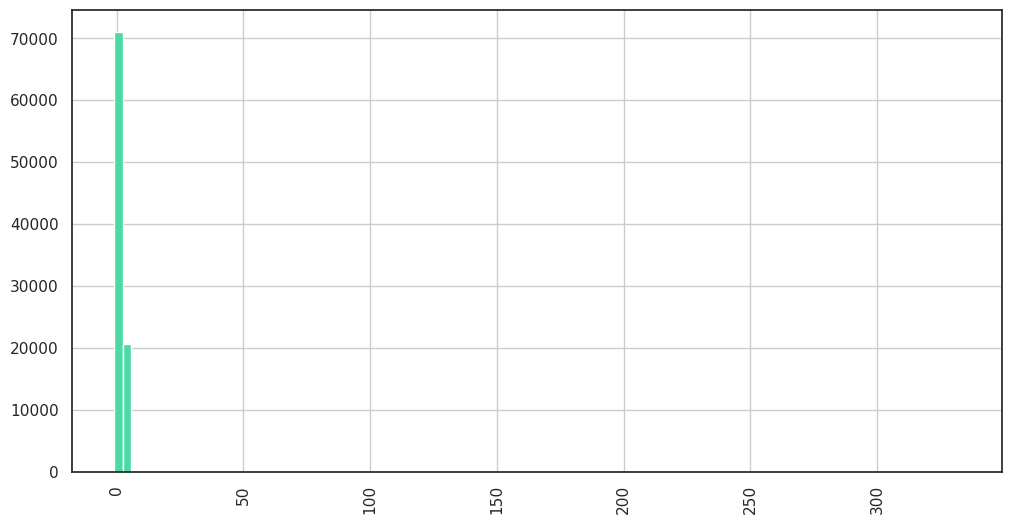

In [ ]:
# Display histogram of charging_time
df_transactions.charging_time.hist(
    bins=100, color=COLOR_LIGHT_GREEN, xrot=90, figsize=(12, 6)
)


In [ ]:
# Check the negative charging time values
df_transactions[df_transactions["charging_time"] < 0]


,session_id,user_id,charger_id,start_time,end_time,kWh_consumed,payment_method,status,charging_time
1096,session_1097,user_801,charger_467,2025-04-18 23:09:29.243000+00:00,2025-04-18 23:01:29.243000+00:00,3463.91,app_wallet,completed,-0.133333
1828,session_1829,user_672,charger_786,2025-03-10 18:06:42.420000+00:00,2025-03-10 17:35:42.420000+00:00,-6.78,RFID,completed,-0.516667
4357,session_4358,user_1255,charger_505,2025-05-22 09:51:27.834000+00:00,2025-05-22 08:54:27.834000+00:00,-11.52,RFID,completed,-0.950000
4610,session_4611,user_1416,charger_2159,2025-04-14 06:57:06.499000+00:00,2025-04-14 06:02:06.499000+00:00,4327.31,RFID,completed,-0.916667
5868,session_5869,user_582,charger_25,2025-01-02 19:31:58.190000+00:00,2025-01-02 19:12:58.190000+00:00,-4.46,RFID,completed,-0.316667
...,...,...,...,...,...,...,...,...,...
97947,session_97948,user_298,charger_2367,2025-01-21 15:03:24.930000+00:00,2025-01-21 14:13:24.930000+00:00,-6.02,RFID,completed,-0.833333
98479,session_98480,user_1063,charger_716,2025-01-09 05:52:59.188000+00:00,2025-01-09 05:10:59.188000+00:00,3358.94,app_wallet,completed,-0.700000
98676,session_98677,user_628,charger_37,2025-01-14 12:26:42.890000+00:00,2025-01-14 11:42:42.890000+00:00,-6.90,app_wallet,completed,-0.733333
98815,session_98816,user_853,charger_1610,2025-04-28 04:08:06.553000+00:00,2025-04-28 03:19:06.553000+00:00,-24.44,RFID,completed,-0.816667


In [ ]:
# Check the very high charging time values (e.g., > 24 hours)
df_transactions[df_transactions["charging_time"] > 10]


,session_id,user_id,charger_id,start_time,end_time,kWh_consumed,payment_method,status,charging_time
479,session_480,user_803,charger_1039,2025-02-08 23:52:00.067000+00:00,2025-02-19 08:17:00.067000+00:00,-46.98,card,completed,248.416667
987,session_988,user_1074,charger_2989,2025-03-03 09:49:41.577000+00:00,2025-03-12 04:19:41.577000+00:00,4278.09,app_wallet,completed,210.500000
1732,session_1733,user_1349,charger_2804,2025-03-04 01:39:17.376000+00:00,2025-03-12 18:29:17.376000+00:00,2132.35,RFID,completed,208.833333
2008,session_2009,user_1409,charger_2587,2025-01-11 08:39:47.084000+00:00,2025-01-18 14:32:47.084000+00:00,-14.78,card,completed,173.883333
2084,session_2085,user_1202,charger_343,2025-05-24 04:51:45.442000+00:00,2025-06-06 09:42:45.442000+00:00,3905.50,card,completed,316.850000
...,...,...,...,...,...,...,...,...,...
96398,session_96399,user_37,charger_1553,2025-03-10 10:59:20.786000+00:00,2025-03-24 07:25:20.786000+00:00,4942.10,card,completed,332.433333
97081,session_97082,user_1529,charger_1899,2025-05-03 07:20:25.024000+00:00,2025-05-16 06:10:25.024000+00:00,2386.70,app_wallet,completed,310.833333
97769,session_97770,user_1061,charger_1604,2025-04-27 06:57:53.002000+00:00,2025-05-10 19:18:53.002000+00:00,6293.88,app_wallet,completed,324.350000
97906,session_97907,user_204,charger_1855,2025-01-20 21:33:26.463000+00:00,2025-02-02 21:45:26.463000+00:00,2122.50,app_wallet,completed,312.200000


<Axes: >

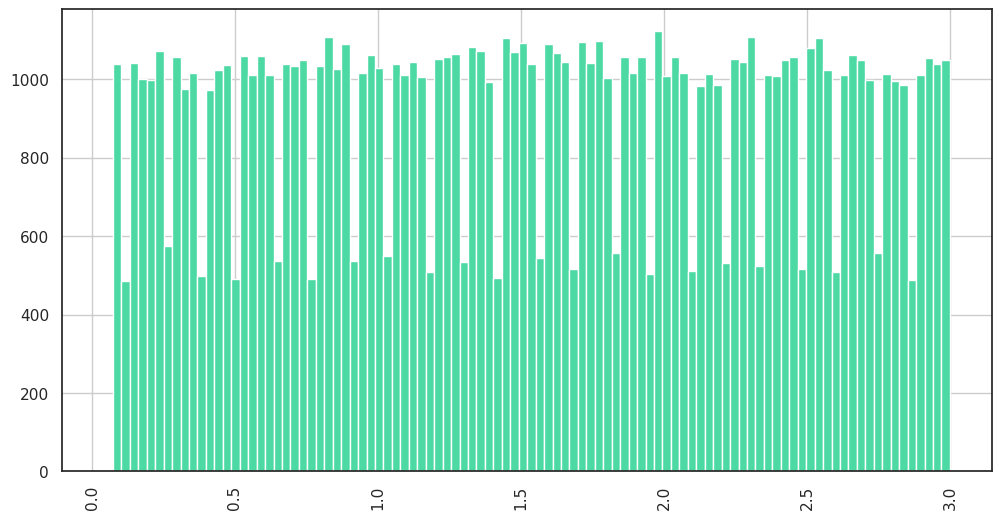

In [ ]:
# Diplay histogram of charging_time after removing outliers
df_transactions_filtered = df_transactions[
    (df_transactions["charging_time"] >= 0) & (df_transactions["charging_time"] <= 10)
]
df_transactions_filtered["charging_time"].hist(
    bins=100, color=COLOR_LIGHT_GREEN, xrot=90, figsize=(12, 6)
)


- `end_time` has some values earlier than `start_time` that need to be handled.
- `kWh_consumed` has some negative values that need to be handled.
- `kWh_consumed` has some very high values that need to be handled.
- `charging_duration` has some very large values that need to be handled.


<a id='opservation'></a>

### Opservations

- **Data Quality Issues**:
  - Chargers DataFrame:
    - Inconsistent city names (e.g., "Zurich" vs. "Zuerich" vs. "Zürich").
    - Invalid values in `latitude` and `longitude` columns.

  - Payments DataFrame:
    - Negative values in `amount` column.
    - Outliers in `amount` column.

  - Users DataFrame:
    No significant data quality issues observed.

  - Transactions DataFrame:
    - `end_time` values earlier than `start_time`.
    - Negative values in `kWh_consumed` column.
    - Outliers in `kWh_consumed` and `charging_duration` columns.


<a id='cleansing'></a>

### Cleansing and Transformation

Based on the assessment, and the observations above we will start cleaning the data to handle the identified issues.


#### Chargers DataFrame

- Standardize city names like "Zurich" and "St. Gallen".
- Identify records with invalid latitude and longitude values.


In [ ]:
# Copy the dataframe for cleansing
df_chargers_cleaned = df_chargers.copy()


In [ ]:
# Standardize city names
df_chargers_cleaned.city.value_counts()


city
Bern            403
Lugano          381
Basel           380
Lausanne        376
Zurich          372
Geneva          370
St. Gallen      361
Lucerne         350
Zuerich           3
Zürich            2
Sankt Gallen      2
Name: count, dtype: int64

In [ ]:
df_chargers_cleaned["city"] = df_chargers_cleaned["city"].replace(
    {
        "Zuerich": "Zurich",
        "Zürich": "Zurich",
        "Sankt Gallen": "St. Gallen",
    }
)


In [ ]:
# Validate the changes
df_chargers_cleaned.city.value_counts()


city
Bern          403
Lugano        381
Basel         380
Zurich        377
Lausanne      376
Geneva        370
St. Gallen    363
Lucerne       350
Name: count, dtype: int64

In [ ]:
# Standardize city_from_coords names to match city column
city_mapping = {
    # Zurich and its districts
    "Zuerich (Kreis 1)": "Zurich",
    "Zuerich (Kreis 2)": "Zurich",
    "Zuerich (Kreis 3)": "Zurich",
    "Zuerich (Kreis 4)": "Zurich",
    "Zuerich (Kreis 5)": "Zurich",
    "Zuerich (Kreis 6)": "Zurich",
    "Zuerich (Kreis 7)": "Zurich",
    "Zuerich (Kreis 8)": "Zurich",
    "Zuerich (Kreis 10)": "Zurich",
    "Zuerich (Kreis 1) / Lindenhof": "Zurich",
    "Zuerich (Kreis 1) / Rathaus": "Zurich",
    "Zuerich (Kreis 1) / City": "Zurich",
    "Zuerich (Kreis 2) / Enge": "Zurich",
    "Zuerich (Kreis 3) / Alt-Wiedikon": "Zurich",
    "Zuerich (Kreis 4) / Langstrasse": "Zurich",
    "Zuerich (Kreis 4) / Werd": "Zurich",
    "Zuerich (Kreis 5) / Gewerbeschule": "Zurich",
    "Zuerich (Kreis 6) / Oberstrass": "Zurich",
    "Zuerich (Kreis 6) / Unterstrass": "Zurich",
    "Zuerich (Kreis 7) / Hottingen": "Zurich",
    "Zuerich (Kreis 7) / Fluntern": "Zurich",
    "Zuerich (Kreis 8) / Muehlebach": "Zurich",
    "Zuerich (Kreis 8) / Seefeld": "Zurich",
    "Zuerich (Kreis 10) / Wipkingen": "Zurich",
    "Aussersihl": "Zurich",
    # St. Gallen region
    "Sankt Gallen": "St. Gallen",
    "Wittenbach": "St. Gallen",
    "Teufen": "St. Gallen",
    # Lucerne region
    "Luzern": "Lucerne",
    "Kriens": "Lucerne",
    "Horw": "Lucerne",
    "Ebikon": "Lucerne",
    "Emmen": "Lucerne",
    # Geneva region
    "Geneve": "Geneva",
    "Le Grand-Saconnex": "Geneva",
    "Carouge": "Geneva",
    "Lancy": "Geneva",
    # Lugano region
    "Sorengo": "Lugano",
    "Viganello": "Lugano",
    "Massagno": "Lugano",
    "Pregassona": "Lugano",
    "Cadempino": "Lugano",
    "Canobbio": "Lugano",
    "Campione": "Lugano",  # Italian enclave near Lugano
    # Bern region
    "Koniz": "Bern",
    "Kehrsatz": "Bern",
    "Muri": "Bern",
    # Basel region
    "Binningen": "Basel",
    "Birsfelden": "Basel",
    "Munchenstein": "Basel",
    "Village-Neuf": "Basel",  # French town on Basel border
    "Weil am Rhein": "Basel",  # German town on Basel border
    # Lausanne region
    "Pully": "Lausanne",
    "Epalinges": "Lausanne",
    "Blecherette": "Lausanne",
}

# Apply the mapping
df_chargers_cleaned["city_from_coords"] = df_chargers_cleaned[
    "city_from_coords"
].replace(city_mapping)
df_chargers_cleaned.city_from_coords.value_counts()


city_from_coords
Bern                           402
Basel                          379
Lugano                         379
Zurich                         376
Lausanne                       372
Geneva                         370
St. Gallen                     359
Lucerne                        346
Tiksi                            4
Anadyr                           4
Moerai                           3
Takoradi                         2
Edinburgh of the Seven Seas      2
Constantia                       1
Hugh Town                        1
Name: count, dtype: int64

In [ ]:
df_chargers_cleaned[["charger_id", "city", "city_from_coords"]].groupby(
    ["city", "city_from_coords"]
).count().reset_index().rename(columns={"charger_id": "count"}).sort_values(
    by="count", ascending=False
)


,city,city_from_coords,count
3,Bern,Bern,402
1,Basel,Basel,379
15,Lugano,Lugano,379
22,Zurich,Zurich,376
7,Lausanne,Lausanne,372
4,Geneva,Geneva,370
19,St. Gallen,St. Gallen,359
11,Lucerne,Lucerne,346
18,St. Gallen,Moerai,2
8,Lausanne,Tiksi,2


In [ ]:
# Flag the records with invalid location
df_chargers_cleaned[df_chargers_cleaned["is_invalid_location"] == False]


,charger_id,city,installed_at,latitude,longitude,is_invalid_location,city_from_coords
0,charger_1,Lausanne,2023-03-26 15:50:52.566000+00:00,46.533429,6.642148,False,Lausanne
1,charger_2,Lucerne,2022-10-08 10:00:41.109000+00:00,47.037157,8.320008,False,Lucerne
2,charger_3,Bern,2024-02-25 12:49:48.493000+00:00,46.957913,7.453251,False,Bern
3,charger_4,Lucerne,2023-08-08 15:48:04.505000+00:00,47.060813,8.312696,False,Lucerne
4,charger_5,Lugano,2023-03-08 15:45:43.325000+00:00,46.011992,8.957525,False,Lugano
...,...,...,...,...,...,...,...
2995,charger_2996,Basel,2025-05-08 07:08:46.719000+00:00,47.568176,7.578654,False,Basel
2996,charger_2997,Zurich,2024-07-24 23:23:45.458000+00:00,47.389826,8.523503,False,Zurich
2997,charger_2998,Lausanne,2023-04-18 15:16:29.187000+00:00,46.524565,6.644819,False,Lausanne
2998,charger_2999,Lugano,2024-02-19 19:08:44.298000+00:00,46.019977,8.944945,False,Lugano


In [ ]:
# Drop the city from coords column
df_chargers_cleaned = df_chargers_cleaned.drop(columns=["city_from_coords"])


Note: will check the chargers with invalid locations against the transactions dataframe in the EDA section to decide whether to drop them or not.


#### Payments DataFrame

- Flag the records with negative values in `amount` column by investigating their origin (e.g., refunds) and deciding whether to correct or remove them.
- Flag the records with outliers in `amount` column using statistical methods (e.g., IQR, Z-score) to identify and handle extreme values.


In [ ]:
# Copy the payments dataframe for cleansing
df_payments_cleaned = df_payments.copy()


In [ ]:
# Flag the records with Negative or zero amount
df_payments_cleaned["is_invalid_amount"] = df_payments_cleaned["amount"] <= 0
df_payments_cleaned["is_invalid_amount"].value_counts()


is_invalid_amount
False    91614
True       262
Name: count, dtype: int64

In [ ]:
# Flag the records with outliers in `kWh_consumed` and `charging_duration` columns.
df_payments_cleaned["is_outlier_amount"] = flag_outliers(df_payments_cleaned["amount"])
df_payments_cleaned["is_outlier_amount"].value_counts()


is_outlier_amount
False    91479
True       397
Name: count, dtype: int64

#### Users DataFrame

    No cleansing needed.


In [ ]:
# Copy the users dataframe for consistency
df_users_cleaned = df_users.copy()


In [ ]:
# Drop the is_valid_email column
df_users_cleaned = df_users_cleaned.drop(columns=["is_valid_email"])


#### Transactions DataFrame

- Flag the records where `end_time` is earlier than `start_time` for further investigation or correction.
- Flag the records where negative values in `kWh_consumed` column.
- Flag the records with outliers in `kWh_consumed` and `charging_duration` columns.


In [ ]:
# Copy the transactions dataframe for cleansing
df_transactions_cleaned = df_transactions.copy()


In [ ]:
# Flag the records where `end_time` is earlier than `start_time` for further investigation or correction.
df_transactions_cleaned["is_end_time_earlier"] = (
    df_transactions_cleaned["end_time"] < df_transactions_cleaned["start_time"]
)


In [ ]:
# Display the count of records with end_time earlier than start_time
df_transactions_cleaned["is_end_time_earlier"].value_counts()


is_end_time_earlier
False    99863
True       137
Name: count, dtype: int64

In [ ]:
# Flag the records where the `kWh_consumed` column has negative values.
df_transactions_cleaned["is_negative_kWh"] = df_transactions_cleaned["kWh_consumed"] < 0


In [ ]:
# Display the count of records with negative kWh_consumed
df_transactions_cleaned["is_negative_kWh"].value_counts()


is_negative_kWh
False    99786
True       214
Name: count, dtype: int64

In [ ]:
# Flag the records with outliers in `kWh_consumed` and `charging_duration` columns.
df_transactions_cleaned["is_outlier_kWh_consumed"] = flag_outliers(
    df_transactions_cleaned["kWh_consumed"]
)

df_transactions_cleaned["is_outlier_charging_time"] = flag_outliers(
    df_transactions_cleaned["charging_time"]
)


In [ ]:
# Display the records with outliers in kWh_consumed
df_transactions_cleaned["is_outlier_kWh_consumed"].value_counts()


is_outlier_kWh_consumed
False    99689
True       311
Name: count, dtype: int64

In [ ]:
# Display the count of outlier records in charging_duration
df_transactions_cleaned["is_outlier_charging_time"].value_counts()


is_outlier_charging_time
False    99857
True       143
Name: count, dtype: int64

<a id='eda'></a>

### Exploratory Data Analysis


Starting by creating an EDA report for each dataframe.


In [ ]:
df_chargers_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   charger_id           3000 non-null   object             
 1   city                 3000 non-null   object             
 2   installed_at         3000 non-null   datetime64[ns, UTC]
 3   latitude             3000 non-null   float64            
 4   longitude            3000 non-null   float64            
 5   is_invalid_location  3000 non-null   bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 120.2+ KB


In [ ]:
report_chargers = ProfileReport(
    df_chargers_cleaned, title="Chargers EDA Report", explorative=True
)
report_chargers.to_file(OUTPUT_DIR / "chargers_eda_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 96.81it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
report_payments = ProfileReport(
    df_payments_cleaned, title="Payments EDA Report", explorative=True
)
report_payments.to_file(OUTPUT_DIR / "payments_eda_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.63it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
report_users = ProfileReport(
    df_users_cleaned, title="Users EDA Report", explorative=True
)
report_users.to_file(OUTPUT_DIR / "users_eda_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.93it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
report_transactions = ProfileReport(
    df_transactions_cleaned,
    title="Transactions EDA Report",
    explorative=True,
    tsmode=True,
)
report_transactions.to_file(OUTPUT_DIR / "transactions_eda_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.54it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/home/ribo/miniconda3/envs/as/lib/python3.13/site-packages/ydata_profiling/visualisation/plot.py:706: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
/home/ribo/miniconda3/envs/as/lib/python3.13/site-packages/ydata_profiling/visualisation/plot.py:706: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Will join the cleaned dataframes together and start the EDA to answer the business questions.


In [ ]:
# Joining the cleaned dataframes to create a master dataframe for analysis.
df_master = (
    df_transactions_cleaned.merge(df_users_cleaned, on="user_id", how="left")
    .merge(df_chargers_cleaned, on="charger_id", how="left")
    .merge(df_payments_cleaned, on="session_id", how="left")
    .rename(
        columns={"user_id_x": "user_id_transactions", "user_id_y": "user_id_payments"}
    )
)


In [ ]:
# Let's first check if the user_id from transactions dataframe matches the user_id from the payments dataframe
mismatched_users = df_master[
    (df_master["user_id_transactions"] != df_master["user_id_payments"])
    & (~df_master["user_id_payments"].isnull())
]
print(f"Number of mismatched user IDs: {mismatched_users.shape[0]}")


Number of mismatched user IDs: 0


In [ ]:
# Remove one of the user_id columns and rename the other
df_master = df_master.drop(columns=["user_id_payments"]).rename(
    columns={"user_id_transactions": "user_id"}
)


In [ ]:
# Add a new column for charging cost per kWh
df_master["cost_per_kWh"] = (df_master["amount"] / df_master["kWh_consumed"]).round(2)
df_master.replace({"cost_per_kWh": {np.inf: np.nan, -np.inf: np.nan}}, inplace=True)


In [ ]:
df_master.columns


Index(['session_id', 'user_id', 'charger_id', 'payment_id', 'tier',
       'installed_at', 'city', 'start_time', 'end_time', 'charging_time',
       'kWh_consumed', 'cost_per_kWh', 'payment_method', 'amount', 'status',
       'is_invalid_location', 'is_end_time_earlier', 'is_negative_kWh',
       'is_outlier_kWh_consumed', 'is_outlier_charging_time',
       'is_invalid_amount', 'is_outlier_amount'],
      dtype='object')

In [ ]:
# Remove unnecessary columns and reorder the remaining columns
cols = [
    "session_id",
    "user_id",
    "charger_id",
    "payment_id",
    "tier",
    "installed_at",
    "city",
    # 'latitude', Not needed for analysis
    # 'longitude', Not needed for analysis
    "start_time",
    "end_time",
    "charging_time",
    "kWh_consumed",
    "cost_per_kWh",
    # 'name', Not needed for analysis
    # 'email', Not needed for analysis
    # 'created_at', Not needed for analysis
    "payment_method",
    "amount",
    # 'currency', Not needed for analysis (all are in CHF)
    "status",
    "is_invalid_location",
    "is_end_time_earlier",
    "is_negative_kWh",
    "is_outlier_kWh_consumed",
    "is_outlier_charging_time",
    "is_invalid_amount",
    "is_outlier_amount",
]

df_master = df_master[cols]
df_master.head()


,session_id,user_id,charger_id,payment_id,tier,installed_at,city,start_time,end_time,charging_time,kWh_consumed,cost_per_kWh,payment_method,amount,status,is_invalid_location,is_end_time_earlier,is_negative_kWh,is_outlier_kWh_consumed,is_outlier_charging_time,is_invalid_amount,is_outlier_amount
0,session_1,user_493,charger_837,payment_1,guest,2025-01-13 04:03:53.978000+00:00,St. Gallen,2025-01-11 09:44:27.416000+00:00,2025-01-11 10:41:27.416000+00:00,0.950000,9.46,0.5,app_wallet,4.73,completed,False,False,False,False,False,False,False
1,session_2,user_189,charger_1355,payment_2,subscriber,2024-09-06 14:59:37.301000+00:00,Lucerne,2025-04-18 12:48:06.929000+00:00,2025-04-18 14:31:06.929000+00:00,1.716667,20.49,0.5,card,10.24,completed,False,False,False,False,False,False,False
2,session_3,user_59,charger_2814,payment_3,guest,2025-03-14 07:12:41.817000+00:00,Bern,2025-03-15 16:04:13.267000+00:00,2025-03-15 16:21:13.267000+00:00,0.283333,4.91,0.5,app_wallet,2.46,completed,False,False,False,False,False,False,False
3,session_4,user_274,charger_1930,payment_4,guest,2022-07-25 06:21:08.226000+00:00,Bern,2025-03-29 15:34:14.324000+00:00,2025-03-29 17:12:14.324000+00:00,1.633333,28.75,0.5,card,14.38,completed,False,False,False,False,False,False,False
4,session_5,user_1825,charger_2625,payment_5,subscriber,2025-02-02 16:35:00.280000+00:00,Lugano,2025-04-23 04:42:51.722000+00:00,2025-04-23 05:36:51.722000+00:00,0.900000,15.67,0.5,app_wallet,7.83,completed,False,False,False,False,False,False,False


In [ ]:
df_master.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   session_id                100000 non-null  object             
 1   user_id                   100000 non-null  object             
 2   charger_id                100000 non-null  object             
 3   payment_id                91876 non-null   object             
 4   tier                      100000 non-null  object             
 5   installed_at              100000 non-null  datetime64[ns, UTC]
 6   city                      100000 non-null  object             
 7   start_time                100000 non-null  datetime64[ns, UTC]
 8   end_time                  91876 non-null   datetime64[ns, UTC]
 9   charging_time             91876 non-null   float64            
 10  kWh_consumed              100000 non-null  float64            
 11  c

In [ ]:
# Add column to indicate any flagged issues in the master dataframe
issue_columns = [
    "is_invalid_amount",
    "is_outlier_amount",
    "is_end_time_earlier",
    "is_negative_kWh",
    "is_outlier_kWh_consumed",
    "is_outlier_charging_time",
    # "is_invalid_location", # Removed as it will effect only the location of the charger
]
df_master["has_issues"] = df_master[issue_columns].any(axis=1)


In [ ]:
# Display the count of records with issues
df_master["has_issues"].value_counts()


has_issues
False    99435
True       565
Name: count, dtype: int64

In [ ]:
# Display the records with issues
df_master_issues = df_master[df_master["has_issues"] == True]
df_master_issues


,session_id,user_id,charger_id,payment_id,tier,installed_at,city,start_time,end_time,charging_time,kWh_consumed,cost_per_kWh,payment_method,amount,status,is_invalid_location,is_end_time_earlier,is_negative_kWh,is_outlier_kWh_consumed,is_outlier_charging_time,is_invalid_amount,is_outlier_amount,has_issues
479,session_480,user_803,charger_1039,payment_436,subscriber,2024-08-21 01:46:38.913000+00:00,Lugano,2025-02-08 23:52:00.067000+00:00,2025-02-19 08:17:00.067000+00:00,248.416667,-46.98,0.5,card,-23.49,completed,False,False,True,True,True,True,True,True
912,session_913,user_1523,charger_2536,payment_842,guest,2022-06-07 02:57:51.815000+00:00,Bern,2025-01-22 21:55:16.614000+00:00,2025-01-22 22:49:16.614000+00:00,0.900000,-9.73,0.5,app_wallet,-4.87,completed,False,False,True,False,False,True,False,True
987,session_988,user_1074,charger_2989,payment_908,subscriber,2022-11-29 19:08:26.961000+00:00,Basel,2025-03-03 09:49:41.577000+00:00,2025-03-12 04:19:41.577000+00:00,210.500000,4278.09,0.5,app_wallet,2139.05,completed,False,False,False,True,True,False,True,True
1096,session_1097,user_801,charger_467,payment_1009,subscriber,2022-10-01 03:39:33.467000+00:00,Lucerne,2025-04-18 23:09:29.243000+00:00,2025-04-18 23:01:29.243000+00:00,-0.133333,3463.91,0.5,app_wallet,1731.95,completed,False,True,False,True,False,False,True,True
1353,session_1354,user_1756,charger_747,payment_1242,subscriber,2024-06-19 22:29:53.668000+00:00,Bern,2025-03-15 20:31:34.258000+00:00,2025-03-15 21:48:34.258000+00:00,1.283333,-44.85,0.5,card,-22.43,completed,False,False,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98755,session_98756,user_1755,charger_1709,payment_90733,subscriber,2022-07-21 02:55:31.822000+00:00,Lucerne,2025-02-25 03:12:01.761000+00:00,2025-02-25 03:50:01.761000+00:00,0.633333,7.09,0.0,app_wallet,0.00,completed,False,False,False,False,False,True,False,True
98815,session_98816,user_853,charger_1610,payment_90787,subscriber,2023-06-11 12:54:35.775000+00:00,Geneva,2025-04-28 04:08:06.553000+00:00,2025-04-28 03:19:06.553000+00:00,-0.816667,-24.44,0.5,RFID,-12.22,completed,False,True,True,True,False,True,True,True
99323,session_99324,user_1755,charger_2018,payment_91256,subscriber,2023-05-17 05:31:20.349000+00:00,Geneva,2025-04-19 15:39:39.513000+00:00,2025-04-19 15:26:39.513000+00:00,-0.216667,-3.51,0.5,app_wallet,-1.75,completed,False,True,True,False,False,True,False,True
99461,session_99462,user_922,charger_579,payment_91380,guest,2024-12-11 02:38:36.277000+00:00,Bern,2025-02-18 03:51:26.956000+00:00,2025-02-18 06:36:26.956000+00:00,2.750000,-12.97,0.5,RFID,-6.49,completed,False,False,True,False,False,True,False,True


In [ ]:
# Check how many records with amount issues
df_master_issues[
    (df_master_issues["is_invalid_amount"] == True)
    | (df_master_issues["is_outlier_amount"] == True)
]


,session_id,user_id,charger_id,payment_id,tier,installed_at,city,start_time,end_time,charging_time,kWh_consumed,cost_per_kWh,payment_method,amount,status,is_invalid_location,is_end_time_earlier,is_negative_kWh,is_outlier_kWh_consumed,is_outlier_charging_time,is_invalid_amount,is_outlier_amount,has_issues
479,session_480,user_803,charger_1039,payment_436,subscriber,2024-08-21 01:46:38.913000+00:00,Lugano,2025-02-08 23:52:00.067000+00:00,2025-02-19 08:17:00.067000+00:00,248.416667,-46.98,0.5,card,-23.49,completed,False,False,True,True,True,True,True,True
912,session_913,user_1523,charger_2536,payment_842,guest,2022-06-07 02:57:51.815000+00:00,Bern,2025-01-22 21:55:16.614000+00:00,2025-01-22 22:49:16.614000+00:00,0.900000,-9.73,0.5,app_wallet,-4.87,completed,False,False,True,False,False,True,False,True
987,session_988,user_1074,charger_2989,payment_908,subscriber,2022-11-29 19:08:26.961000+00:00,Basel,2025-03-03 09:49:41.577000+00:00,2025-03-12 04:19:41.577000+00:00,210.500000,4278.09,0.5,app_wallet,2139.05,completed,False,False,False,True,True,False,True,True
1096,session_1097,user_801,charger_467,payment_1009,subscriber,2022-10-01 03:39:33.467000+00:00,Lucerne,2025-04-18 23:09:29.243000+00:00,2025-04-18 23:01:29.243000+00:00,-0.133333,3463.91,0.5,app_wallet,1731.95,completed,False,True,False,True,False,False,True,True
1353,session_1354,user_1756,charger_747,payment_1242,subscriber,2024-06-19 22:29:53.668000+00:00,Bern,2025-03-15 20:31:34.258000+00:00,2025-03-15 21:48:34.258000+00:00,1.283333,-44.85,0.5,card,-22.43,completed,False,False,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98755,session_98756,user_1755,charger_1709,payment_90733,subscriber,2022-07-21 02:55:31.822000+00:00,Lucerne,2025-02-25 03:12:01.761000+00:00,2025-02-25 03:50:01.761000+00:00,0.633333,7.09,0.0,app_wallet,0.00,completed,False,False,False,False,False,True,False,True
98815,session_98816,user_853,charger_1610,payment_90787,subscriber,2023-06-11 12:54:35.775000+00:00,Geneva,2025-04-28 04:08:06.553000+00:00,2025-04-28 03:19:06.553000+00:00,-0.816667,-24.44,0.5,RFID,-12.22,completed,False,True,True,True,False,True,True,True
99323,session_99324,user_1755,charger_2018,payment_91256,subscriber,2023-05-17 05:31:20.349000+00:00,Geneva,2025-04-19 15:39:39.513000+00:00,2025-04-19 15:26:39.513000+00:00,-0.216667,-3.51,0.5,app_wallet,-1.75,completed,False,True,True,False,False,True,False,True
99461,session_99462,user_922,charger_579,payment_91380,guest,2024-12-11 02:38:36.277000+00:00,Bern,2025-02-18 03:51:26.956000+00:00,2025-02-18 06:36:26.956000+00:00,2.750000,-12.97,0.5,RFID,-6.49,completed,False,False,True,False,False,True,False,True


- All records with issues has eaither negative/zero amount or outlier amount.


Text(0, 0.5, 'Count')

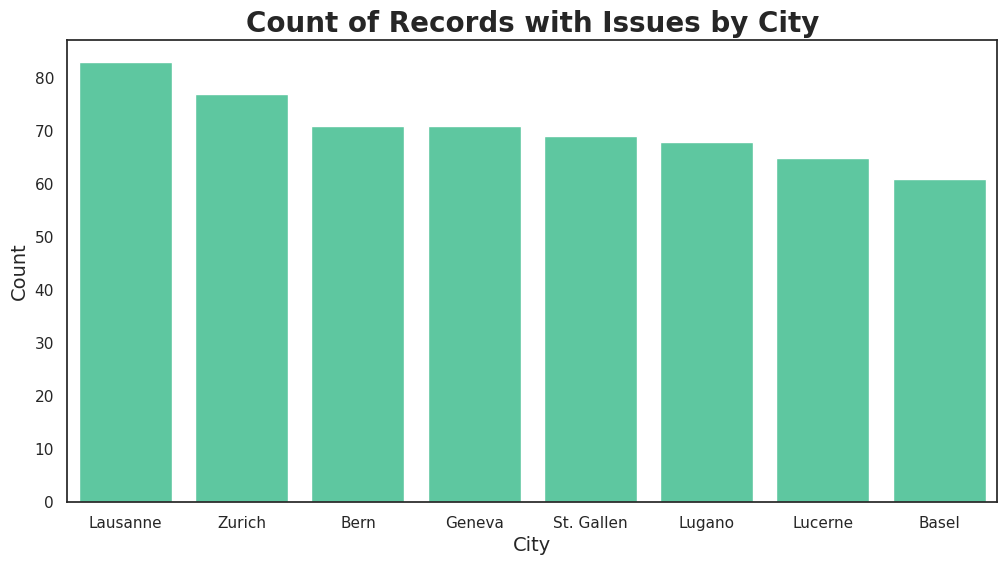

In [ ]:
# Plot the count of records for each city in the issues dataframe
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_master_issues,
    x="city",
    order=df_master_issues["city"].value_counts().index,
    color=COLOR_LIGHT_GREEN,
)
plt.title("Count of Records with Issues by City", **TITLEFONT)
plt.xlabel("City", **AXISFONT)
plt.ylabel("Count", **AXISFONT)


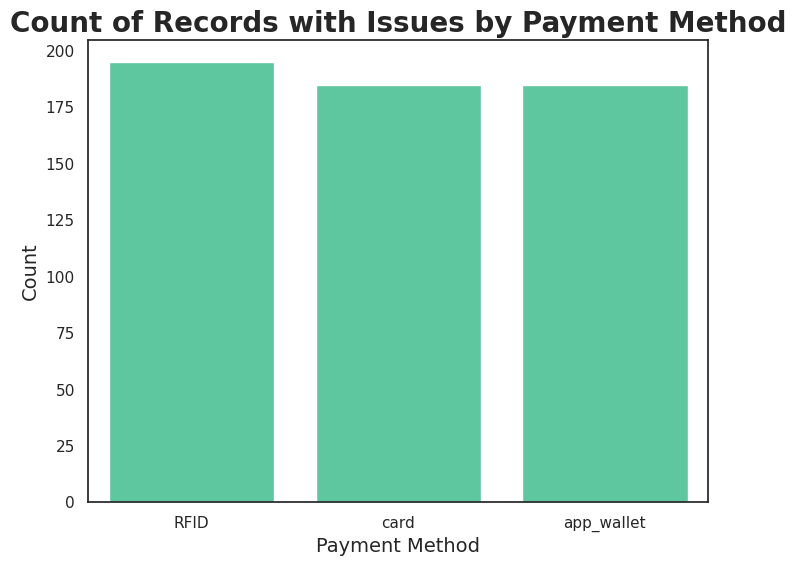

In [ ]:
# Plot the count of records for each payment method in the issues dataframe
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_master_issues,
    x="payment_method",
    order=df_master_issues["payment_method"].value_counts().index,
    color=COLOR_LIGHT_GREEN,
)
plt.title("Count of Records with Issues by Payment Method", **TITLEFONT)
plt.xlabel("Payment Method", **AXISFONT)
plt.ylabel("Count", **AXISFONT)
plt.show()


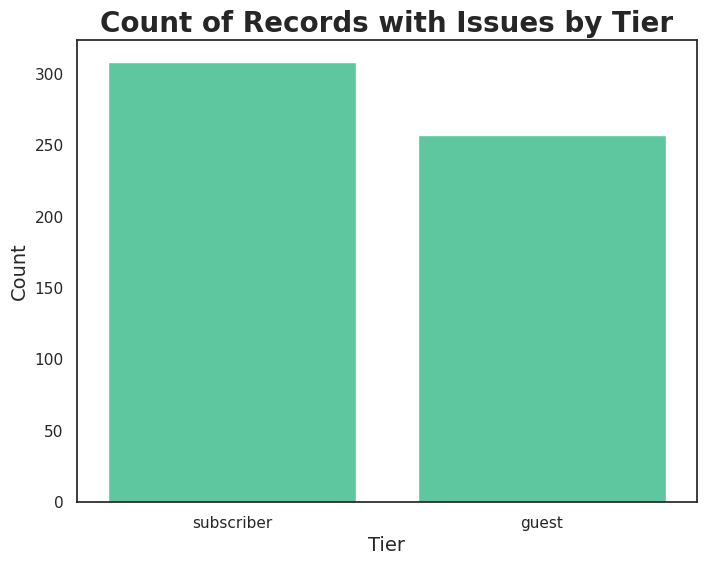

In [ ]:
# Plot the count of records for each tier in the issues dataframe
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_master_issues,
    x="tier",
    order=df_master_issues["tier"].value_counts().index,
    color=COLOR_LIGHT_GREEN,
)
plt.title("Count of Records with Issues by Tier", **TITLEFONT)
plt.xlabel("Tier", **AXISFONT)
plt.ylabel("Count", **AXISFONT)
plt.show()


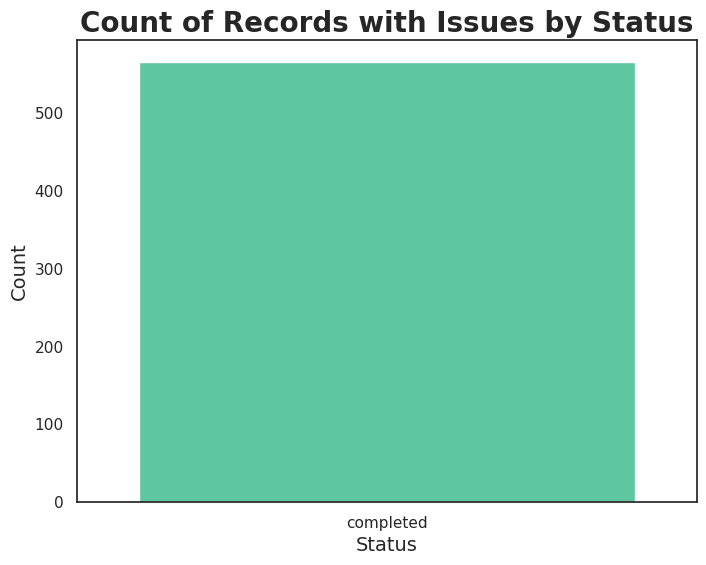

In [ ]:
# Plot the count of records for each status
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_master_issues,
    x="status",
    order=df_master_issues["status"].value_counts().index,
    color=COLOR_LIGHT_GREEN,
)
plt.title("Count of Records with Issues by Status", **TITLEFONT)
plt.xlabel("Status", **AXISFONT)
plt.ylabel("Count", **AXISFONT)
plt.show()


In [ ]:
# Create report for the master dataframe
report_master = ProfileReport(
    df_master, title="Master Dataframe EDA Report", explorative=True
)
report_master.to_file(OUTPUT_DIR / "master_dataframe_eda_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.57it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Create a crosstab showing correlation between different data quality issues
# For each pair of issues, count how many records have both issues

# Create an empty dataframe to store the crosstab results
crosstab_df = pd.DataFrame(index=issue_columns, columns=issue_columns, dtype=int)

# Calculate the count of records that have both issues for each pair
for row_issue in issue_columns:
    for col_issue in issue_columns:
        # Count records where both issues are True
        count = df_master[
            (df_master[row_issue] == True) & (df_master[col_issue] == True)
        ].shape[0]
        crosstab_df.loc[row_issue, col_issue] = count

# Make the upper triangle null to remove redundant information
import numpy as np

mask = np.triu(np.ones_like(crosstab_df, dtype=bool), k=1)
crosstab_df = crosstab_df.mask(mask)

# Display the crosstab
print("Crosstab of Data Quality Issues (count of records with both issues):")
print("=" * 100)
crosstab_df


Crosstab of Data Quality Issues (count of records with both issues):


,is_invalid_amount,is_outlier_amount,is_end_time_earlier,is_negative_kWh,is_outlier_kWh_consumed,is_outlier_charging_time
is_invalid_amount,262.0,NaN,NaN,NaN,NaN,NaN
is_outlier_amount,94.0,397.0,NaN,NaN,NaN,NaN
is_end_time_earlier,95.0,62.0,137.0,NaN,NaN,NaN
is_negative_kWh,214.0,94.0,95.0,214.0,NaN,NaN
is_outlier_kWh_consumed,84.0,311.0,60.0,84.0,311.0,NaN
is_outlier_charging_time,38.0,131.0,0.0,38.0,126.0,143.0


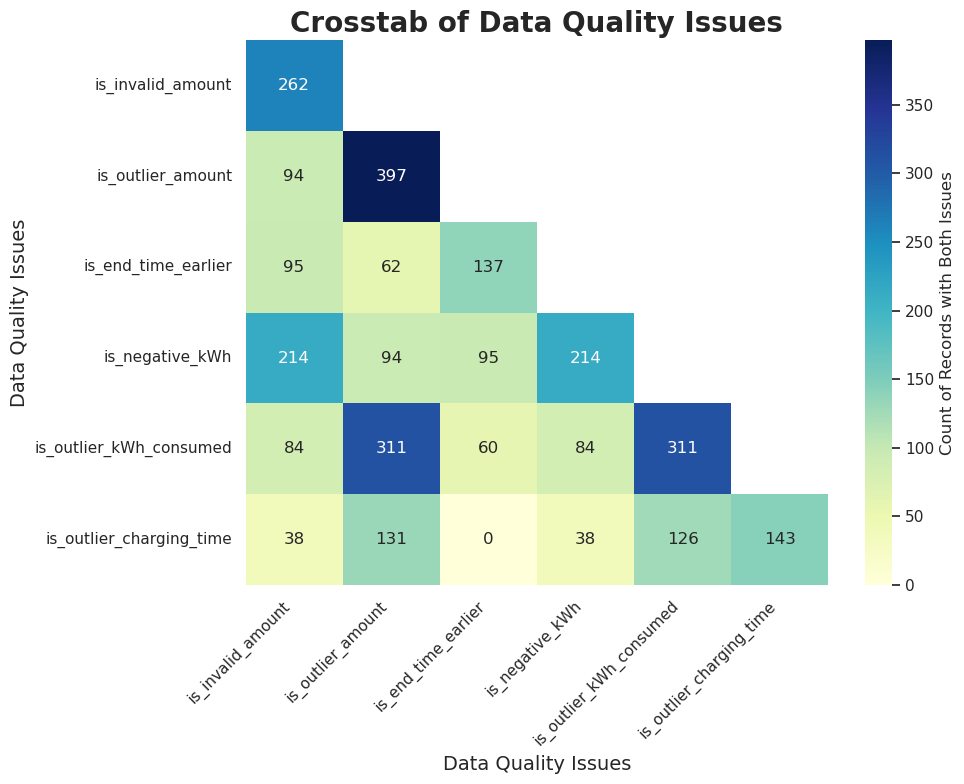

In [ ]:
# Visualize the crosstab using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    crosstab_df,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    cbar_kws={"label": "Count of Records with Both Issues"},
    mask=crosstab_df.isna(),
)
plt.title("Crosstab of Data Quality Issues", **TITLEFONT)
plt.xlabel("Data Quality Issues", **AXISFONT)
plt.ylabel("Data Quality Issues", **AXISFONT)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()


In [ ]:
# Sum the total number of issues per record
df_master["total_issues"] = df_master[issue_columns].sum(axis=1)
# Display the distribution of total issues per record
df_master["total_issues"].value_counts().sort_index()


total_issues
0    99435
1      124
2      113
3      237
4       52
5       39
Name: count, dtype: int64

In [ ]:
# Check the cost_per_kWh for the payments with 0 or negative amount
df_master_issues.cost_per_kWh.value_counts()


cost_per_kWh
0.50        472
0.00         49
3493.20       1
888.91        1
11713.63      1
9484.36       1
5055.23       1
9700.11       1
0.48          1
3250.40       1
2251.00       1
1783.08       1
1245.36       1
8383.48       1
37127.66      1
3054.82       1
2074.82       1
3677.63       1
4981.16       1
325.87        1
4538.74       1
386.41        1
4077.97       1
4653.85       1
632.07        1
23993.92      1
70647.36      1
4567.42       1
2630.32       1
9674.08       1
7709.11       1
1017.71       1
1844.86       1
6194.07       1
8111.72       1
5345.58       1
4068.01       1
3537.09       1
2599.53       1
4641.83       1
2233.37       1
29090.83      1
11829.16      1
3857.70       1
784.95        1
1659.92       1
Name: count, dtype: int64

In [ ]:
# Check the cost_per_kWh distribution
df_master.cost_per_kWh.value_counts()


cost_per_kWh
0.50        91484
0.49          162
0.51          137
0.00           49
3493.20         1
888.91          1
11713.63        1
9484.36         1
5055.23         1
9700.11         1
0.48            1
3250.40         1
2251.00         1
1783.08         1
1245.36         1
8383.48         1
37127.66        1
3054.82         1
2074.82         1
3677.63         1
4981.16         1
325.87          1
4538.74         1
386.41          1
4077.97         1
4653.85         1
632.07          1
23993.92        1
70647.36        1
4567.42         1
2630.32         1
9674.08         1
7709.11         1
1017.71         1
1844.86         1
6194.07         1
8111.72         1
5345.58         1
4068.01         1
3537.09         1
2599.53         1
4641.83         1
2233.37         1
29090.83        1
11829.16        1
3857.70         1
784.95          1
1659.92         1
Name: count, dtype: int64

In [ ]:
# Get the number of payments with 0 or negative amounts and negative or zero charging time against the number of payments with positive charging time
num_invalid_payments_negative_time = df_master_issues[
    (df_master_issues["charging_time"] <= 0) & (df_master_issues["amount"] <= 0)
].shape[0]
num_invalid_payments_positive_time = df_master_issues[
    (df_master_issues["charging_time"] > 0) & (df_master_issues["amount"] <= 0)
].shape[0]
print(
    f"Number of payments with 0 or negative amount and negative or zero charging time: {num_invalid_payments_negative_time}"
)
print(
    f"Number of payments with 0 or negative amount and positive charging time: {num_invalid_payments_positive_time}"
)


Number of payments with 0 or negative amount and negative or zero charging time: 95
Number of payments with 0 or negative amount and positive charging time: 167


The negative amounts were not due to negative duration charging and no clear pattern for the dates.


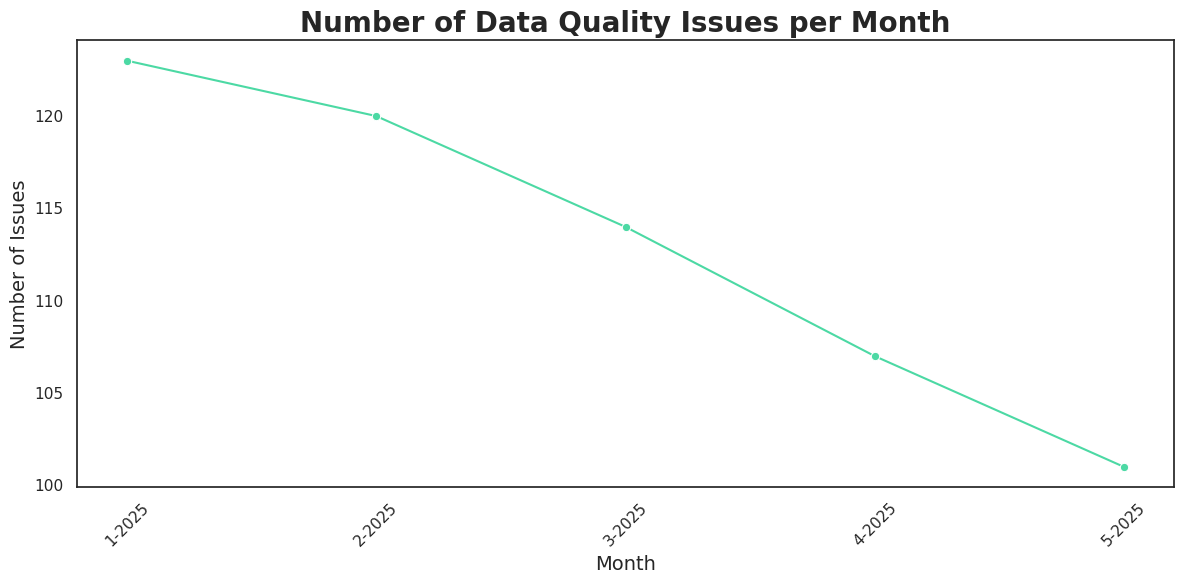

In [ ]:
# Visualize the data quality issues per month
df_master["month_year"] = (
    df_master["start_time"].dt.month.astype(str)
    + "-"
    + df_master["start_time"].dt.year.astype(str)
)
issues_per_month = (
    df_master.groupby("month_year")["has_issues"]
    .sum()
    .reset_index()
    .rename(columns={"has_issues": "num_issues"})
)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=issues_per_month,
    x="month_year",
    y="num_issues",
    marker="o",
    color=COLOR_LIGHT_GREEN,
)
# plt.ylim(bottom=0)
plt.title("Number of Data Quality Issues per Month", **TITLEFONT)
plt.xlabel("Month", **AXISFONT)
plt.ylabel("Number of Issues", **AXISFONT)
plt.xticks(rotation=45)
plt.tight_layout()


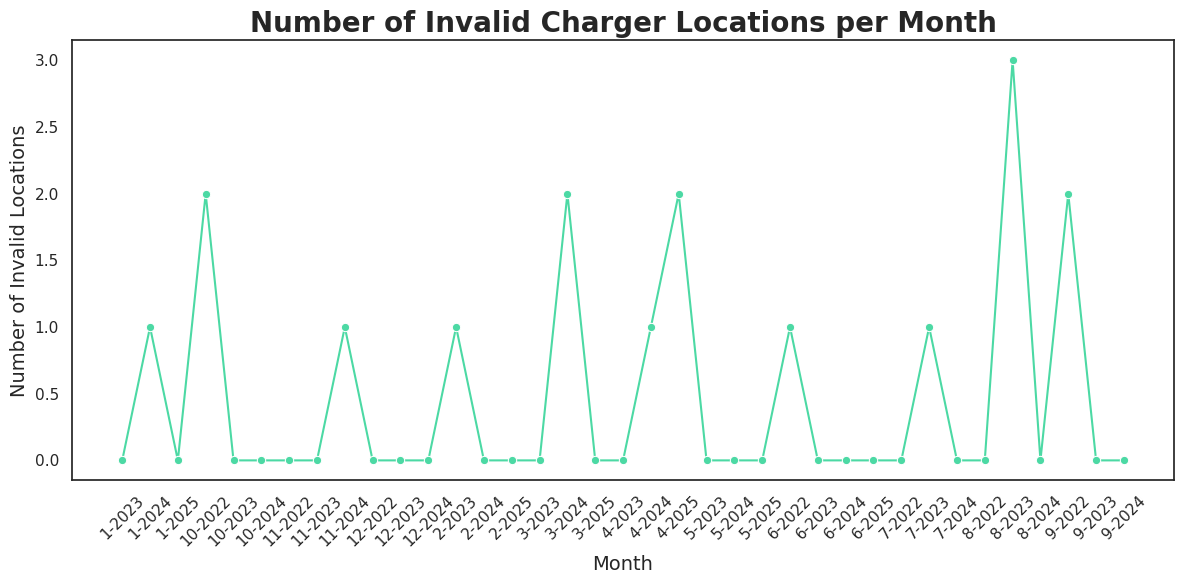

In [ ]:
# Plot the trend of invalid locations over time from the chargers dataframe
df_chargers_cleaned["month_year"] = (
    df_chargers_cleaned["installed_at"].dt.month.astype(str)
    + "-"
    + df_chargers_cleaned["installed_at"].dt.year.astype(str)
)
invalid_locations_per_month = (
    df_chargers_cleaned.groupby("month_year")["is_invalid_location"]
    .sum()
    .reset_index()
    .rename(columns={"is_invalid_location": "num_invalid_locations"})
)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=invalid_locations_per_month,
    x="month_year",
    y="num_invalid_locations",
    marker="o",
    color=COLOR_LIGHT_GREEN,
)
# plt.ylim(bottom=0)
plt.title("Number of Invalid Charger Locations per Month", **TITLEFONT)
plt.xlabel("Month", **AXISFONT)
plt.ylabel("Number of Invalid Locations", **AXISFONT)
plt.xticks(rotation=45)
plt.tight_layout()


##### Exploring the data excluding the flagged records


In [ ]:
# Create a copy of the master dataframe excluding records with issues for further analysis
df_master_cleaned = df_master[df_master["has_issues"] == False].copy()


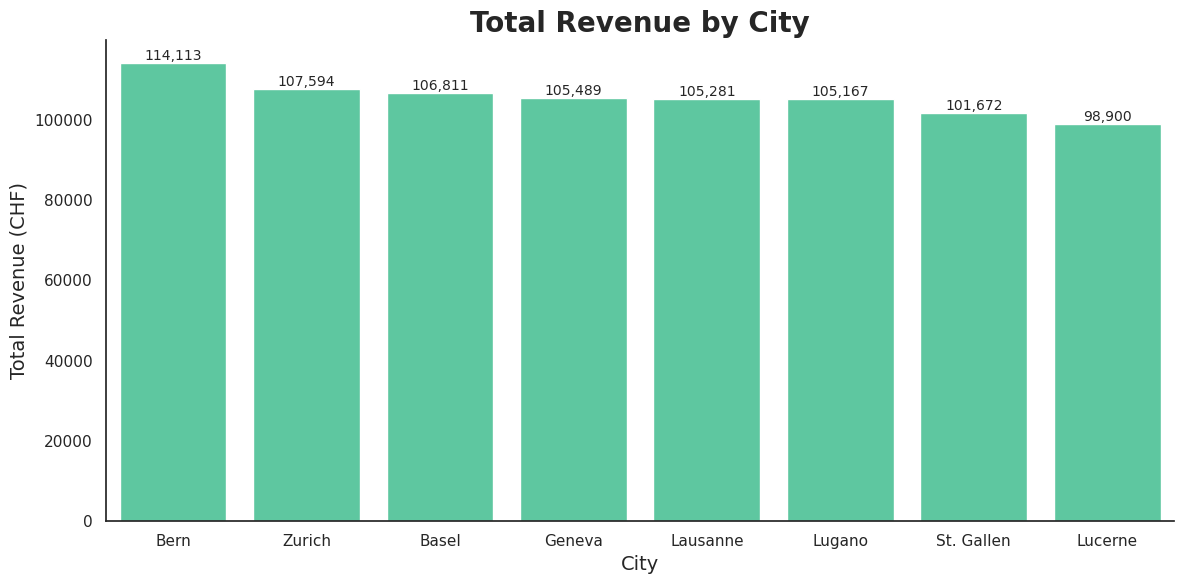

In [ ]:
# Revenue Distribution by City - Bar chart showing total revenue per city
revenue_by_city = (
    df_master_cleaned.groupby("city")["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "total_revenue"})
    .sort_values(by="total_revenue", ascending=False)
)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    data=revenue_by_city,
    x="city",
    y="total_revenue",
    order=revenue_by_city["city"],
    color=COLOR_LIGHT_GREEN,
    ax=ax,
)

# Add value labels on top of bars with thousand separator
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:,.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Remove right and bottom spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.title("Total Revenue by City", **TITLEFONT)
plt.xlabel("City", **AXISFONT)
plt.ylabel("Total Revenue (CHF)", **AXISFONT)
plt.tight_layout()


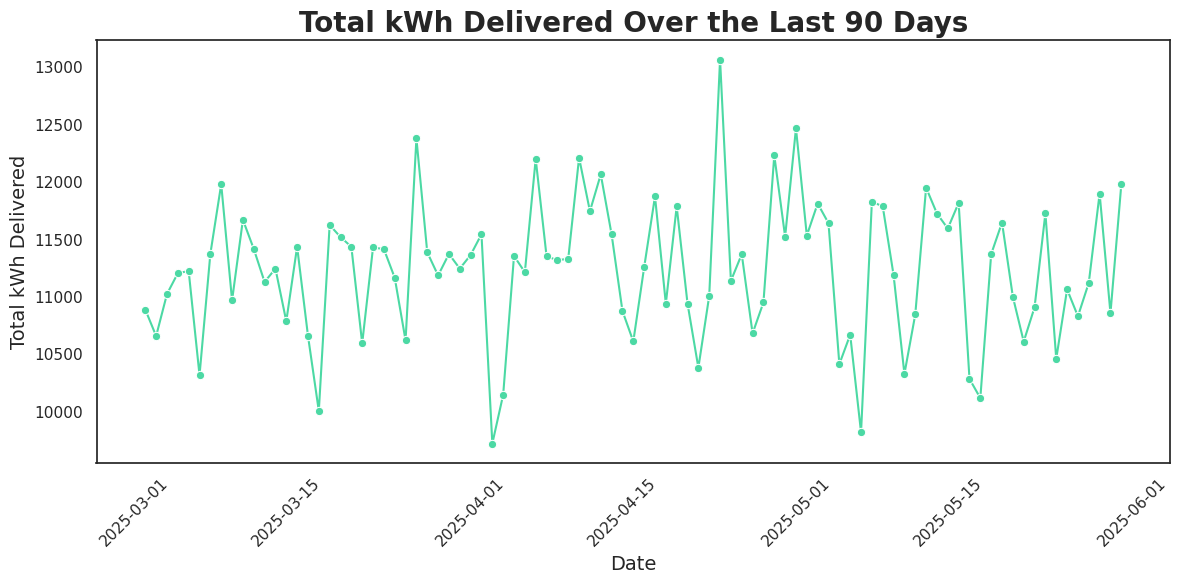

In [ ]:
# Energy Consumption Trends - Time series of total kWh delivered for the last 90 days
df_master_cleaned["date"] = df_master_cleaned["start_time"].dt.date
kwh_trends = (
    df_master_cleaned.groupby("date")["kWh_consumed"]
    .sum()
    .reset_index()
    .rename(columns={"kWh_consumed": "total_kWh"})
)
# Filter for last 90 days
kwh_trends = kwh_trends[
    kwh_trends["date"] >= (kwh_trends["date"].max() - pd.Timedelta(days=90))
]
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=kwh_trends,
    x="date",
    y="total_kWh",
    marker="o",
    color=COLOR_LIGHT_GREEN,
)
plt.title("Total kWh Delivered Over the Last 90 Days", **TITLEFONT)
plt.xlabel("Date", **AXISFONT)
plt.ylabel("Total kWh Delivered", **AXISFONT)
plt.xticks(rotation=45)
plt.tight_layout()


In [ ]:
# Energy Consumption Trends with City Filter Widget
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

# Prepare the data
df_master_cleaned["date"] = df_master_cleaned["start_time"].dt.date


def plot_kwh_trends_by_city(city="All Cities"):
    """
    Plot kWh consumption trends for the selected city over the last 90 days.

    Parameters:
    -----------
    city : str
        City name or "All Cities" for combined view
    """
    # Filter data by city if not "All Cities"
    if city == "All Cities":
        filtered_data = df_master_cleaned.copy()
        title_suffix = ""
    else:
        filtered_data = df_master_cleaned[df_master_cleaned["city"] == city].copy()
        title_suffix = f" - {city}"

    # Aggregate by date
    kwh_trends = (
        filtered_data.groupby("date")["kWh_consumed"]
        .sum()
        .reset_index()
        .rename(columns={"kWh_consumed": "total_kWh"})
    )

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.lineplot(
        data=kwh_trends,
        x="date",
        y="total_kWh",
        marker="o",
        color=COLOR_LIGHT_GREEN,
        linewidth=2,
        markersize=4,
        ax=ax,
    )

    # Remove right and top spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle="--")

    plt.title(f"Total kWh Delivered{title_suffix}", **TITLEFONT)
    plt.xlabel("Date", **AXISFONT)
    plt.ylabel("Total kWh Delivered", **AXISFONT)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# Get list of cities and add "All Cities" option
cities = ["All Cities"] + sorted(df_master_cleaned["city"].unique().tolist())

# Create interactive widget
interact(
    plot_kwh_trends_by_city,
    city=widgets.Dropdown(
        options=cities,
        value="All Cities",
        description="City:",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="300px"),
    ),
)


interactive(children=(Dropdown(description='City:', layout=Layout(width='300px'), options=('All Cities', 'Base…

<function __main__.plot_kwh_trends_by_city(city='All Cities')>

#### Conclusions
